In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns 
import xgboost as xgb


color_pal = sns.color_palette()

In [54]:
df = pd.read_csv('PJME_hourly.csv')

In [55]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [56]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [57]:
df.shape

(145366, 2)

In [58]:
df = df.set_index('Datetime')


In [59]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


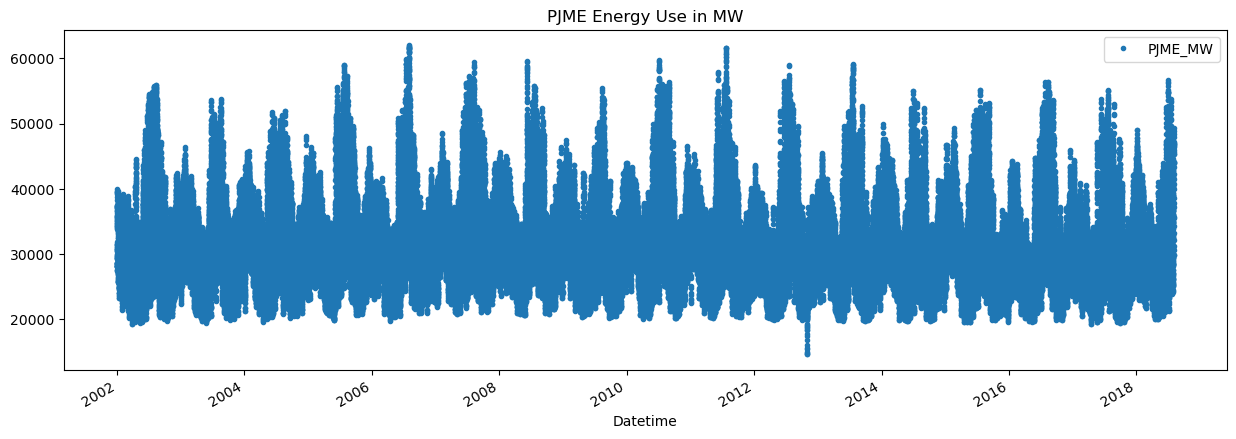

In [64]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title = 'PJME Energy Use in MW')
plt.show()

In [61]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [62]:
df.index = pd.to_datetime(df.index)

In [63]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

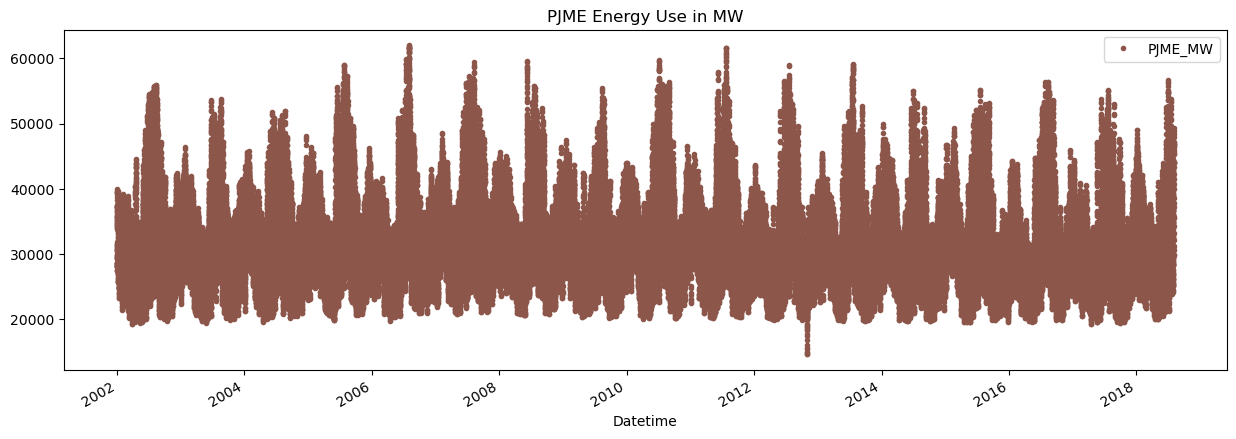

In [76]:
df.plot(style='.',
        figsize=(15, 5), 
        color=color_pal[5], 
        title = 'PJME Energy Use in MW')
plt.show()

In [74]:
df.isnull().sum()

PJME_MW    0
dtype: int64

## Train / Test Split 

In [75]:
 df.loc[df.index < '01-01-2015']

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0
